# ELT Example: API → Google Sheets

This notebook demonstrates a practical ELT-style workflow using
a PostgreSQL-backed API as the data source and Google Sheets as the
analysis and transformation layer.

The focus is on approach, tooling, and tradeoffs rather than volume of data.

## Context & Constraints

This example was built specifically for portfolio purposes.

Professional work performed in enterprise environments cannot be shared due
to intellectual property ownership and access restrictions. This notebook
demonstrates equivalent concepts using publicly accessible tools.

The goal is to showcase:
- Data extraction from APIs
- Spreadsheet automation
- Business-facing transformations

## Workflow Overview (ELT Pattern)

This example follows an ELT-style approach:

1. **Extract** data from an application API
2. **Load** raw data into Google Sheets
3. **Transform** data using spreadsheet-native tools

This mirrors how many analytics workflows operate outside of traditional
data warehouses.

## Extract: API-Based Data Access

Data is retrieved from a PostgreSQL-backed application via custom API
endpoints. Responses are returned in JSON format.

The extract step focuses on:
- Authentication
- API response handling
- JSON structure awareness

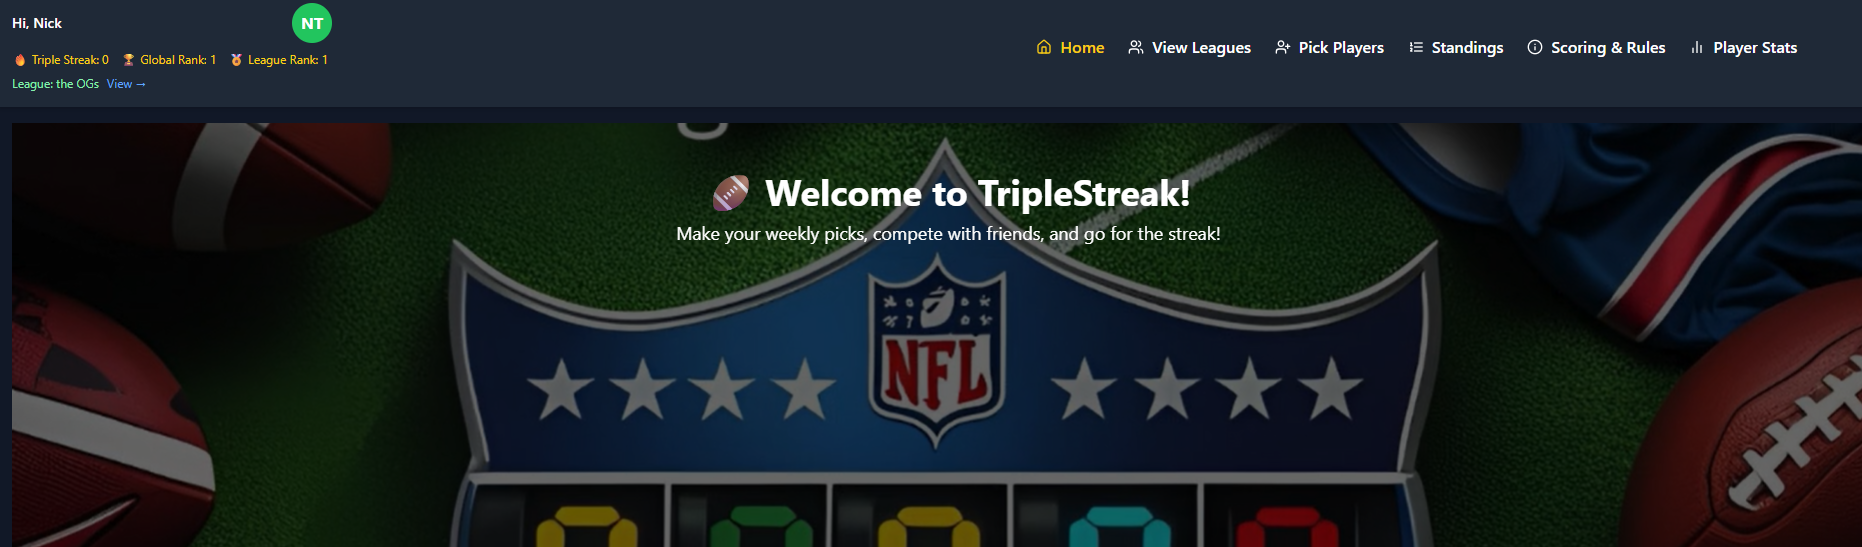

## Load: Google Sheets via Apps Script

Raw API responses are loaded into Google Sheets using Google Apps Script.

This approach allows:
- Dynamic API calls from Sheets
- JSON parsing and flattening
- Automated refresh without manual downloads

### Google Apps Script Loader

The following script:
- Fetches JSON from an API endpoint
- Flattens nested objects
- Outputs a tabular structure usable in Sheets


```javascript
function loadAllPlayerStatsDynamic() {
  const ss = SpreadsheetApp.getActiveSpreadsheet();
  const sheet = ss.getSheetByName("PlayerStats");
  const playerSheet = ss.getSheetByName("QBStatsWeek14");

  sheet.clear();

  const playerIds = playerSheet
    .getRange("A2:A" + playerSheet.getLastRow())
    .getValues()
    .flat()
    .filter(String);

  if (playerIds.length === 0) throw new Error("No player IDs found.");

  let allRowsObjects = [];  // store each row as object
  let allHeadersSet = new Set();

  // 1️⃣ Fetch and flatten all players first
  playerIds.forEach(id => {
    const url = `https://fantasy-nfl-app.fly.dev/api/players/${id}/stats?season=2025`;

    try {
      const response = UrlFetchApp.fetch(url);
      const stats = JSON.parse(response.getContentText());
      if (!Array.isArray(stats) || stats.length === 0) return;

      stats.forEach(stat => {
        const flat = flattenJsonAndHeadersSingle(stat); // returns a flat object
        flat.requested_player_id = id; // prepend player ID
        Object.keys(flat).forEach(k => allHeadersSet.add(k));
        allRowsObjects.push(flat);
      });

    } catch (e) {
      const errObj = { requested_player_id: id, ERROR: e.toString() };
      Object.keys(errObj).forEach(k => allHeadersSet.add(k));
      allRowsObjects.push(errObj);
    }
  });

  if (allRowsObjects.length === 0) return;

  // 2️⃣ Build final header (ensure requested_player_id first)
  const allHeaders = Array.from(allHeadersSet);
  const header = ["requested_player_id", ...allHeaders.filter(h => h !== "requested_player_id")];
  sheet.getRange(1, 1, 1, header.length).setValues([header]);

  // 3️⃣ Build 2D array matching header order
  const allRows = allRowsObjects.map(rowObj => header.map(h => rowObj[h] ?? ""));

  // 4️⃣ Write all rows safely
  sheet.getRange(2, 1, allRows.length, header.length).setValues(allRows);
}
```

### Example: Raw API Data in Google Sheets

Below is an example of the extracted API data loaded into a structured
Google Sheets tab.


![Data Load in Sheet Example](../images/PlayerStatsTbl.png)

## Transform: Spreadsheet-Based Business Logic

Once data is loaded into Sheets, transformations are applied using
spreadsheet-native tools commonly used by analysts and business users.

These transformations include:
- Pivot tables
- Lookup functions
- Calculated fields


### Example Transformations

The following examples demonstrate how raw data is reshaped for
analysis and reporting.





#### Pivot Tables
Used to aggregate metrics by category and time period.

![PivotSheets Example](../images/PivotSheetsEx.png)


#### Lookup Functions (XLOOKUP / INDEX-MATCH)
Used to enrich datasets with reference values.

![PivotSheets Example](../images/IndexMatchEx.png)


Explanation of formula: Match returns the data row where lookup value is first found. Index then looks in a cell range and returns the value at r, c where row is one match value and column is another match value. The column to reference is handled with a dynamic value from a formula (Team).

## Summary

This notebook demonstrates a realistic ELT workflow using:
- API-driven extraction
- Spreadsheet automation
- Business-facing transformation logic

While simplified for public sharing, the concepts mirror workflows used
in production analytics environments.


## What This Demonstrates

- ELT pipeline design
- API data ingestion
- Spreadsheet automation with Apps Script
- Translation of Excel-based logic into cloud tools
- Working within real-world constraints
